In [8]:
# Hyperparameters
seq_length = 20 #length of window
batch_size = 32
input_channels = 1  # Input has 1 channel (1D time series)
output_channels = 1  # Output has 1 channel (1D time series)
kernel_size = 3
num_filters = 32
num_layers = 2
learning_rate = 0.0001
num_epochs = 100

In [9]:
def normalize(train_data):
    mins = np.min(train_data, axis=1, keepdims=True)
    maxs = np.max(train_data, axis=1, keepdims=True)
    normalized_train = (train_data - mins) / (maxs - mins)
    params = {'mins': mins, 'maxs': maxs}   
    return normalized_train, params

def denormalize(normalized_train, params):
    mins = params['mins']
    maxs = params['maxs']
    denormalized_train = normalized_train * (maxs - mins) + mins    
    return denormalized_train

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import maketab as mt

In [11]:
"""
def load_data(path_dir):
    t = mt.time(path_dir)
    tleft = 1 - t / max(t)
    motor = mt.readcsv(path_dir+'motor.csv')
    motor = (motor/65535)*100
    thr = mt.thrust(path_dir)
    av = mt.ang_vel(path_dir)
    #me = thr*0.05*av*0.1
    me = ((thr[1]/4)*av[1] + (thr[2]/4)*av[2] + (thr[3]/4)*av[3] + (thr[4]/4)*av[4])*0.047*0.1*0.05
    return me, tleft, t
"""
#"""
def load_data(path_dir):
    t, signal = mt.battery(path_dir)
    tleft = 1 - t / max(t)
    return signal, tleft, t
#"""

train_data = load_data('data/5-2-25/')
test_data = load_data('data/4-2-25/')
train_data, train_param = normalize(train_data)
test_data, test_param = normalize(test_data)

In [12]:
def prepare_data(data, seq_length):
    input_data = data[0]
    output_data = data[1]
    xs, ys = [], []
    for i in range(len(input_data) - seq_length):
        x = input_data[i:i + seq_length]  # Input sequence (noisy nonlinear)
        y = output_data[i:i + seq_length]  # Output sequence (linear)
        xs.append(x)
        ys.append(y)
    xs = np.array(xs)
    ys = np.array(ys)
    X_train = torch.tensor(xs, dtype=torch.float32).unsqueeze(1)  # Add channel dimension: (batch_size, 1, seq_length)
    y_train = torch.tensor(ys, dtype=torch.float32).unsqueeze(1)  # Add channel dimension: (batch_size, 1, seq_length)
    return X_train, y_train

X_train, y_train = prepare_data(train_data, seq_length)
X_test, y_test = prepare_data(test_data, seq_length)

# Create training DataLoader for batching
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
# Define a 1D CNN model
class CNNCurveTransformer(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, num_filters=32, num_layers=2):
        super(CNNCurveTransformer, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Add convolutional layers
        for i in range(num_layers):
            in_channels = input_channels if i == 0 else num_filters
            self.conv_layers.append(nn.Conv1d(in_channels, num_filters, kernel_size, padding='same'))
            self.conv_layers.append(nn.ReLU())

        # Fully connected layers
        self.fc1 = nn.Linear(num_filters * (seq_length // (2 ** num_layers)), seq_length)
        self.fc2 = nn.Linear(seq_length, seq_length)

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
            if isinstance(layer, nn.Conv1d):
                x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.unsqueeze(1)  # Reshape to (batch_size, 1, seq_length)

# Initialize model, loss, and optimizer
model = CNNCurveTransformer(input_channels, output_channels, kernel_size, num_filters, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
def train(dataset):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}')

train(dataset)

Epoch [10/100], Loss: 0.0019
Epoch [20/100], Loss: 0.0008
Epoch [30/100], Loss: 0.0004
Epoch [40/100], Loss: 0.0002
Epoch [50/100], Loss: 0.0001


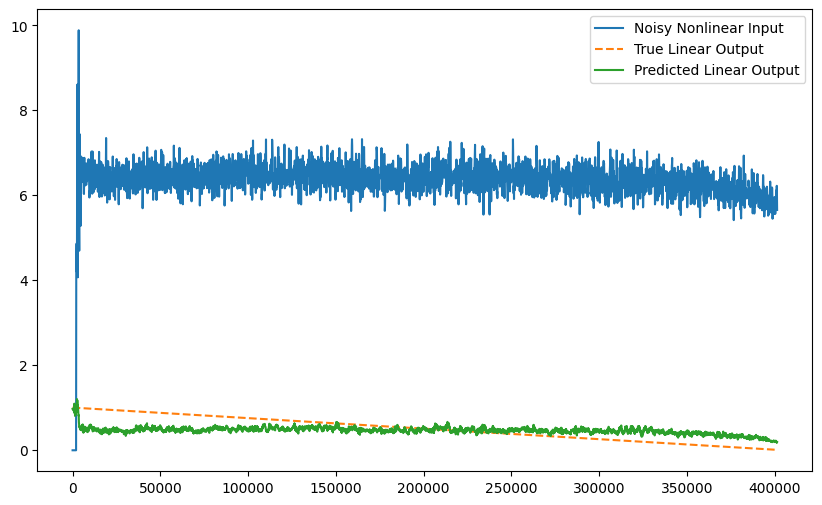

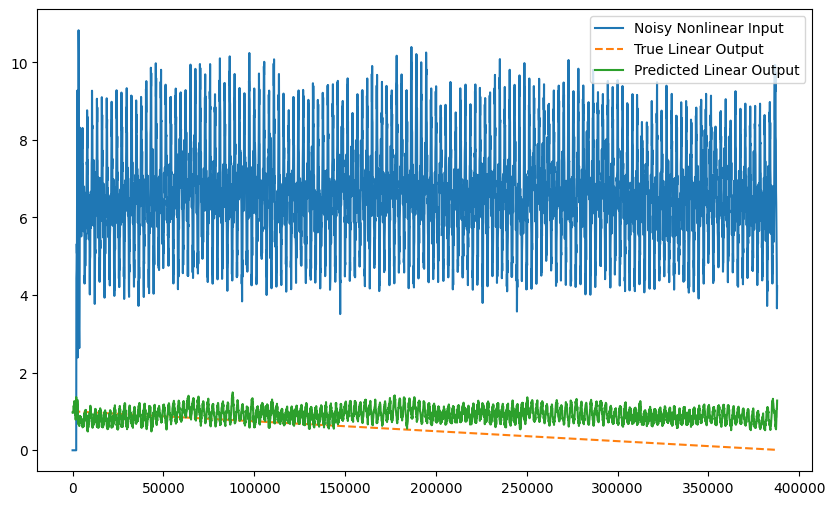

In [11]:
# Test the model
def test(X, data):
    model.eval()
    with torch.no_grad():
        predicted = model(X).squeeze().numpy()
    
    # Plot results
    t = data[2]
    plt.figure(figsize=(10, 6))
    plt.plot(t[:len(predicted)], data[0][:len(predicted)], label='Noisy Nonlinear Input')
    plt.plot(t[:len(predicted)], data[1][:len(predicted)], label='True Linear Output', linestyle='--')
    #plt.plot(t[:len(predicted)], predicted.mean(axis=1), label='Predicted Linear Output')
    plt.plot(t[:len(predicted)], predicted[:, 0], label='Predicted Linear Output')
    plt.legend()
    plt.show()

test(X_train, train_data)
test(X_test, test_data)